# Amazon Fashion Product Analytics

## Initial setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import re

In [2]:
df = pd.read_csv('amazon_co-ecommerce_sample.csv')
df.head(2)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      10000 non-null  object 
 1   product_name                                 10000 non-null  object 
 2   manufacturer                                 9993 non-null   object 
 3   price                                        8565 non-null   object 
 4   number_available_in_stock                    7500 non-null   object 
 5   number_of_reviews                            9982 non-null   object 
 6   number_of_answered_questions                 9235 non-null   float64
 7   average_review_rating                        9982 non-null   object 
 8   amazon_category_and_sub_category             9310 non-null   object 
 9   customers_who_bought_this_item_also_bought   8938 non-null   object 
 10 

## Data cleaning

### Overview

In [4]:
num_rows = len(df)
df.isnull().sum() * 100 / num_rows    # percentage of null entries

uniq_id                                         0.00
product_name                                    0.00
manufacturer                                    0.07
price                                          14.35
number_available_in_stock                      25.00
number_of_reviews                               0.18
number_of_answered_questions                    7.65
average_review_rating                           0.18
amazon_category_and_sub_category                6.90
customers_who_bought_this_item_also_bought     10.62
description                                     6.51
product_information                             0.58
product_description                             6.51
items_customers_buy_after_viewing_this_item    30.65
customer_questions_and_answers                 90.86
customer_reviews                                0.21
sellers                                        30.82
dtype: float64

### 0. Drop duplicate rows and unuseful data

In [5]:
df.drop_duplicates(inplace=True)
df.drop('uniq_id', axis='columns', inplace=True)
df.shape[0]

10000

There were no duplicates in the dataset

### 1. Drop columns with high rate of missing values

```customer_questions_and_answers``` has 90.86% missing values. It's best to drop this column unless there is a specific reason to keep it.

In [6]:
df.drop('customer_questions_and_answers', axis='columns', inplace=True)

### 2. Drop columns if filling does not make sense

All other columns are allowed to have null entries, so we will not drop any.

### 3. Drop rows with missing or unreliable values 

Since we will be performing analysis on reviews and ratings, we will drop the rows with no reviews or no rating.

In [7]:
df.dropna(axis='index', subset=['manufacturer', 'customer_reviews', 'average_review_rating', 'price'], inplace=True)
df = df.loc[ df['price'].str.contains(r'^£[0-9]+\.[0-9]+$') ]
df.shape[0]

8524

### 4. Drop duplicate columns

In [8]:
different_rows = df.loc[
    (df['description'] != df['product_description']) &
        (~df['description'].isna()) &
        (~df['product_description'].isna()),
    ['description', 'product_description']
]

len(different_rows)

1

In [9]:
description = different_rows.iloc[0]['description']
product_description = different_rows.iloc[0]['product_description']

print(description[:40])
print(product_description[:40])

#productDescription .aplus-3p {width: 97
#productDescription .aplus-3p {width: 97


They look very similar but they are not the same. Let's check if one contains the other one before using advanced diff tools.

In [10]:
print(product_description.startswith(description))
print(description.startswith(product_description))

True
False


In [11]:
product_description[len(description):len(description) + 200]

' Experience a new kind of building toy that engages and teaches your child while having fun! Not limited to building straight up like other brick toys, our 3-D design allows your child to build in all'

`product_description` contains some additional information so we will drop the `description` column.

In [12]:
df.drop('description', axis='columns', inplace=True)

### 5. Drop biased columns and dataset imposed limitations

Since we are working on a subset, the `category` and `subcategory` are highly biased, so we will drop the relative column.
Also, the `customers_who_bought_this_item_also_bought` and `items_customers_buy_after_viewing_this_item` cannot be processed because the referred items do not belong in the dataset generally. `customer_reviews` is a non-representative subset of all reviews, so it cannot be included in the analysis.

In [13]:
droppable_cols = [
    'amazon_category_and_sub_category', 
    'customers_who_bought_this_item_also_bought', 
    'items_customers_buy_after_viewing_this_item',
    'customer_reviews'
]
df.drop(droppable_cols, axis='columns', inplace=True)

### 6. Fill where it makes sense

In [14]:
df.fillna({'number_of_answered_questions': 0}, inplace=True)
df.fillna({'product_description': ''}, inplace=True)
df.fillna({'product_information': ''}, inplace=True)

### 7. Converting types

In [15]:
df['price'] = df['price'].str.replace('£', '').astype(float)
df['number_of_reviews'] = df['number_of_reviews'].str.replace(',', '').astype(int)
df['number_of_answered_questions'] = df['number_of_answered_questions'].astype(int)
df['average_review_rating'] = df['average_review_rating'].str[:3].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8524 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   product_name                  8524 non-null   object 
 1   manufacturer                  8524 non-null   object 
 2   price                         8524 non-null   float64
 3   number_available_in_stock     6317 non-null   object 
 4   number_of_reviews             8524 non-null   int32  
 5   number_of_answered_questions  8524 non-null   int32  
 6   average_review_rating         8524 non-null   float64
 7   product_information           8524 non-null   object 
 8   product_description           8524 non-null   object 
 9   sellers                       6046 non-null   object 
dtypes: float64(2), int32(2), object(6)
memory usage: 665.9+ KB


## Data Wrangling

The data was scraped and when `number_available_in_stock` is null, it means that the website did not show the stock, and this happens when the stock amount is big.

### Stock availability

In [16]:
df['in_stock_new'] = False
df['in_stock_used'] = False

df.fillna({'number_available_in_stock': '1 new'}, inplace=True)
df.loc[ df['number_available_in_stock'].str.contains('new'), 'in_stock_new' ] = True 
df.loc[ df['number_available_in_stock'].str.contains('used'), 'in_stock_used' ] = True

In [17]:
df.drop('number_available_in_stock', axis='columns', inplace=True)

### Competition price extraction


In [18]:
df['sellers'] = df['sellers'].fillna(value='')

In [19]:
price_pattern = r'£(\d+\.\d{2})'

df['other_prices'] = df['sellers'].apply(lambda x: re.findall(price_pattern, x))
df['other_prices'] = df['other_prices'].apply(lambda prices: [float(price) for price in prices] if prices else []) 
df['other_prices'].head(5)

0    [3.42, 0.19, 9.99, 8.0, 37.62]
1                           [16.99]
2                      [9.99, 29.9]
3                                []
4                                []
Name: other_prices, dtype: object

### Mean price among competition

In [20]:
df['mean_price'] = [
    np.mean(prices) if prices else this_price for this_price, prices in df[['price', 'other_prices']].values 
]

df['mean_price'].head(5)

0    11.844
1    16.990
2    19.945
3    39.990
4    32.190
Name: mean_price, dtype: float64

In [21]:
df.drop('sellers', axis='columns', inplace=True)

### Price variance

In [22]:
df['price_variance'] = df.apply(
    lambda row: np.var([row['price']] + row['other_prices']), axis=1
)

df['price_variance'].head(5)

0    158.088633
1      0.000000
2     88.090689
3      0.000000
4      0.000000
Name: price_variance, dtype: float64

## Data Analysis

### Correlation matrix

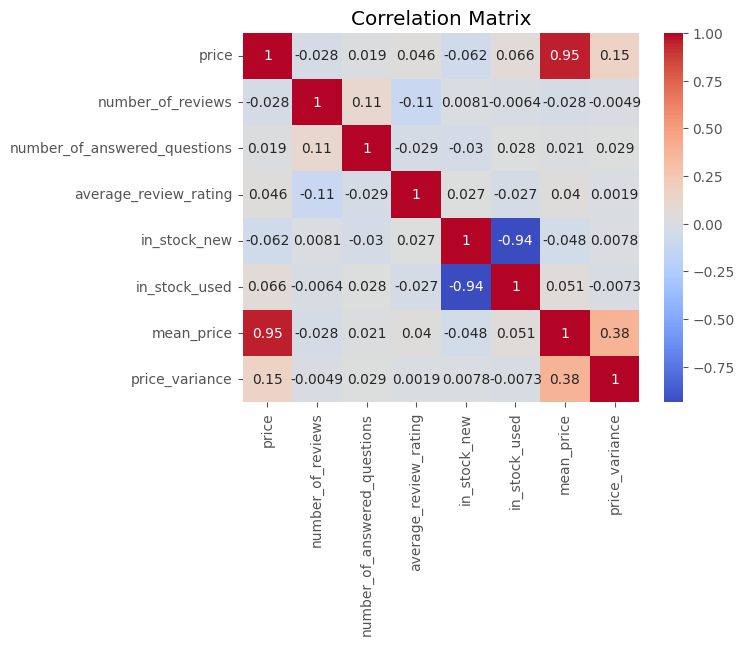

In [23]:
numeric_df = df.select_dtypes(include=['number', 'bool'])

correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Pareto principle

According to the Pareto principle, the 80% of the products are produced by 20% of manufacturers. The pie chart below shows almost perfectly this theory.

In [24]:
grouped_df = df.groupby('manufacturer').size().reset_index(name='count')
sorted_df = grouped_df.sort_values(by='count', ascending=False)

threshold = sorted_df['count'].quantile(0.2)

top_20 = sorted_df.loc[ sorted_df['count'] > threshold ]
bottom_80 = sorted_df.loc[ sorted_df['count'] <= threshold ]

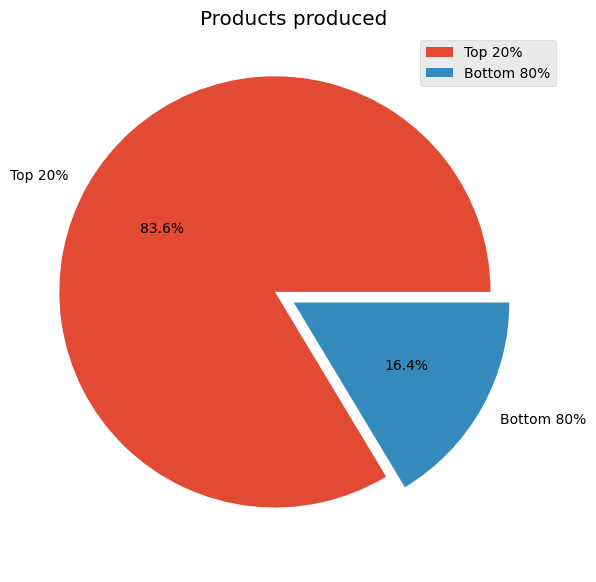

In [25]:
top_20_sum = top_20['count'].sum()
bottom_80_sum = bottom_80['count'].sum()

labels = ['Top 20%', 'Bottom 80%']
data = [top_20_sum, bottom_80_sum]

plt.figure(figsize=(10, 7))
plt.pie(data, labels=labels, startangle=0, explode=(0.1, 0), autopct='%1.1f%%')
plt.legend(labels)
plt.title('Products produced')
plt.show()

### Average rating of manufacturers

<Axes: title={'center': 'Average rating of manufacturers'}, xlabel='Rating', ylabel='Number of manufacturers'>

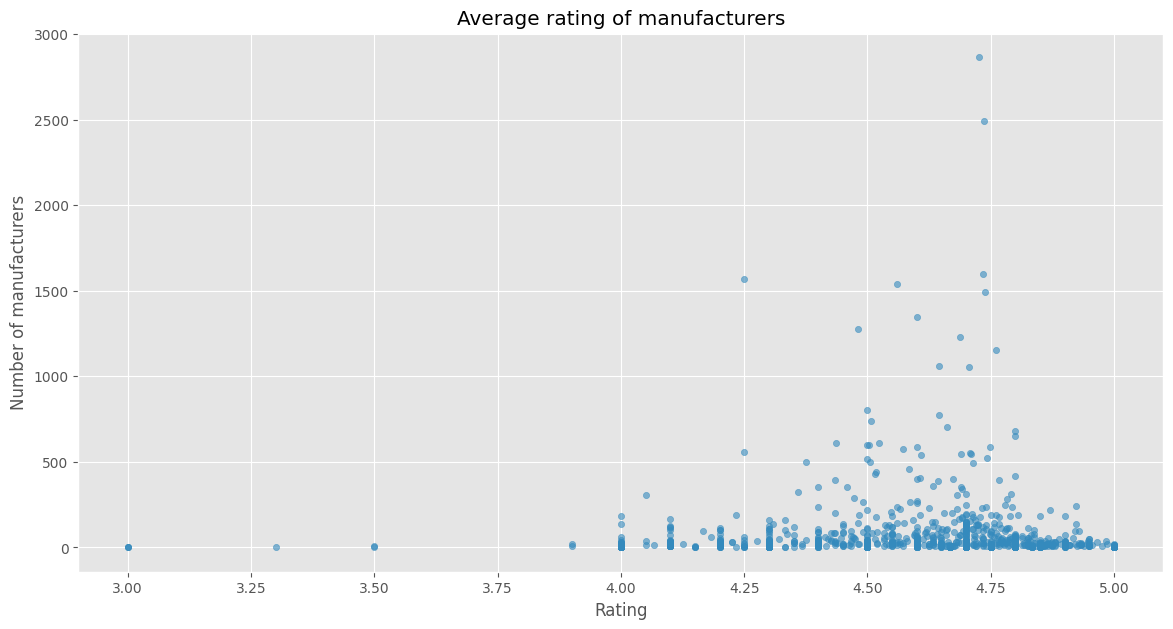

In [26]:
manufacturer_data = df.groupby('manufacturer').agg({
    'average_review_rating': 'mean',
    'number_of_reviews': 'sum',
}).reset_index()

fig, ax = plt.subplots(figsize=(14, 7))

manufacturer_data.plot(
    kind='scatter',
    x='average_review_rating',
    y='number_of_reviews',
    title='Average rating of manufacturers',
    xlabel='Rating',
    ylabel='Number of manufacturers',
    ax=ax,
    alpha=0.6
)

### Price vs Average rating: percieved sense of worth

<Axes: title={'center': 'Price vs Average rating'}, xlabel='Rating', ylabel='Price'>

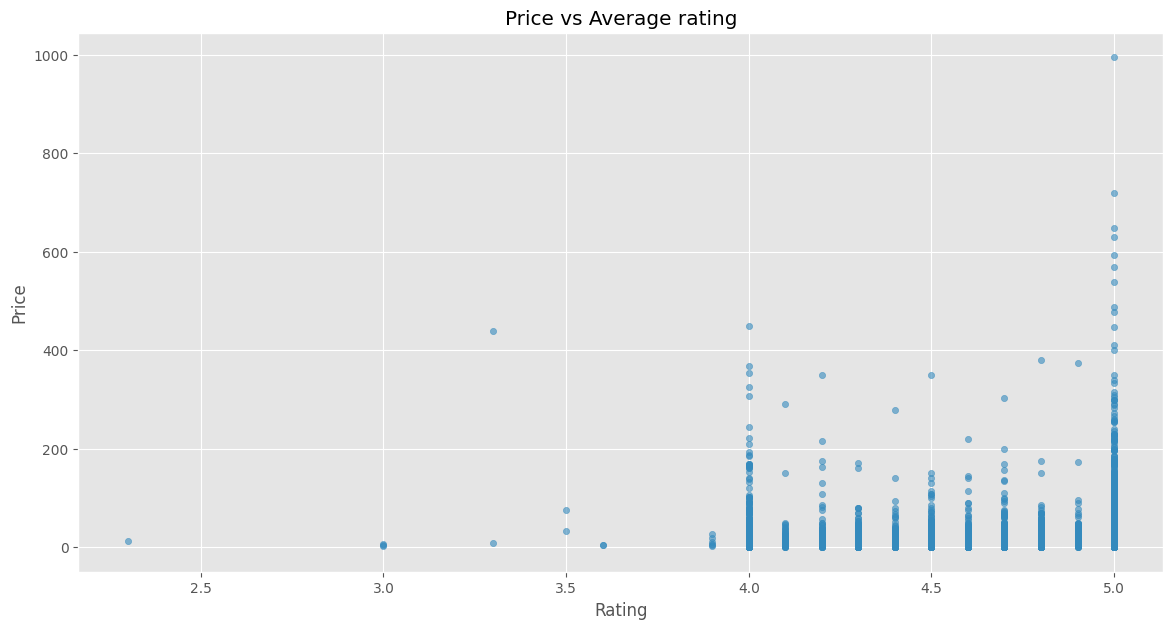

In [27]:
fig, ax = plt.subplots(figsize=(14, 7))

df.plot(
    kind='scatter',
    x='average_review_rating',
    y='price',
    title='Price vs Average rating',
    xlabel='Rating',
    ylabel='Price',
    ax=ax,
    alpha=0.6
)

### Number of products by average rating

<Axes: title={'center': 'Number of products by average rating (ylim=1000)'}, xlabel='Average review rating', ylabel='Number of products'>

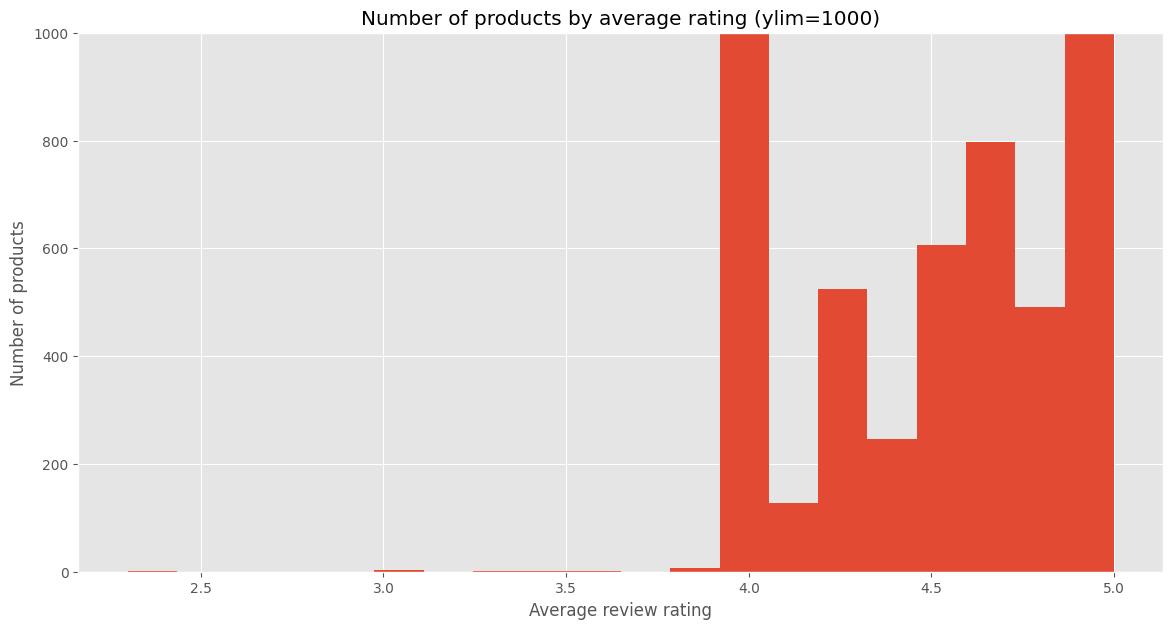

In [28]:
fig, ax = plt.subplots(figsize=(14, 7))

df['average_review_rating'].plot(
    kind='hist',
    bins=20,
    ax=ax,
    ylim=(0, 1000),
    xlabel='Average review rating',
    ylabel='Number of products',
    title='Number of products by average rating (ylim=1000)'
)

### Number of Answered Questions vs Number of Reviews

<Axes: title={'center': 'Number of Answered Questions vs Number of Reviews'}, xlabel='Number of Answered Questions', ylabel='Number of Reviews'>

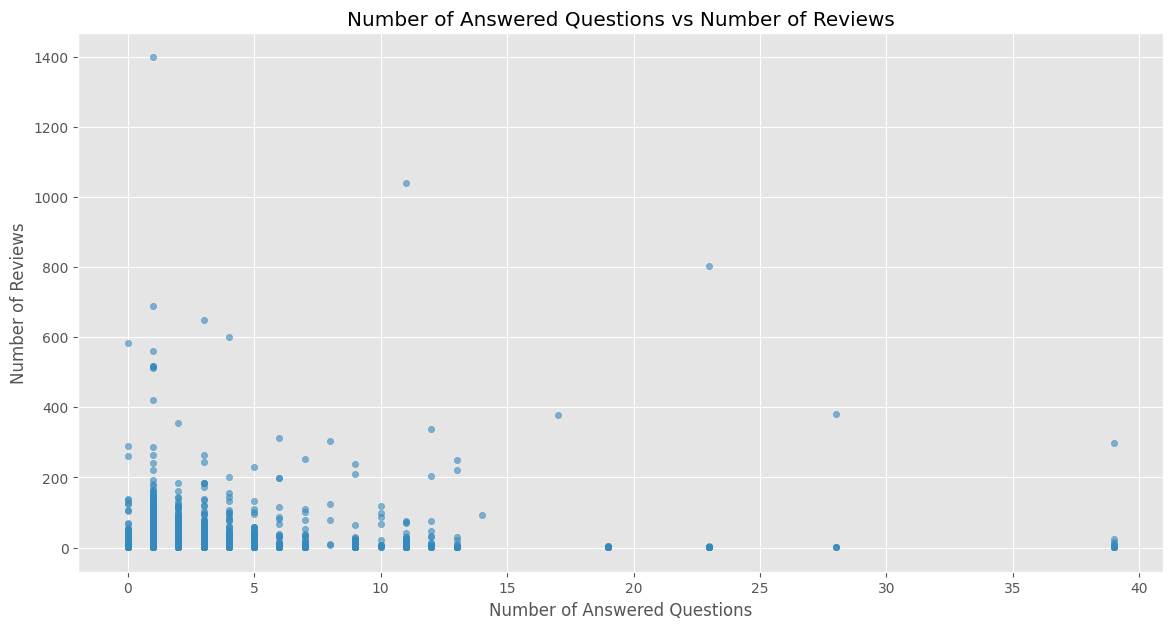

In [29]:
fig, ax = plt.subplots(figsize=(14, 7))

df.plot(
    kind='scatter',
    x='number_of_answered_questions',
    y='number_of_reviews',
    title='Number of Answered Questions vs Number of Reviews',
    xlabel='Number of Answered Questions',
    ylabel='Number of Reviews',
    ax=ax,
    alpha=0.6
)

### Stock availability

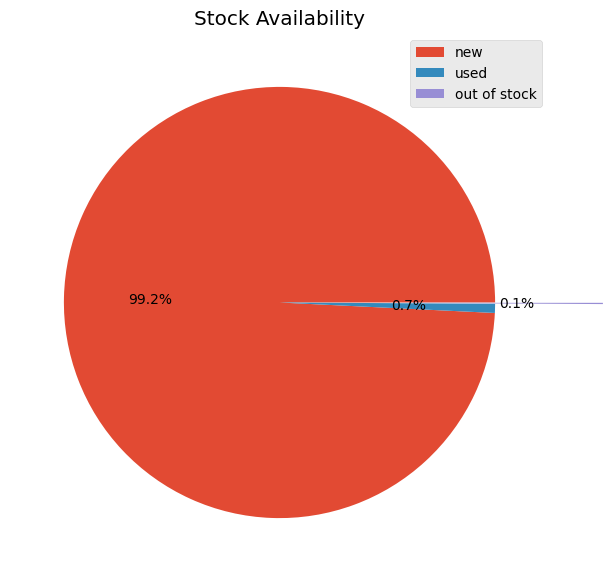

In [30]:
new_count = df['in_stock_new'].sum()
used_count = df['in_stock_used'].sum()
stock_counts = [
    new_count,
    used_count,
    len(df) - new_count - used_count
]

plt.figure(figsize=(14, 7))
plt.pie(
    stock_counts, 
    explode=(0, 0, 0.5), 
    autopct='%1.1f%%', 
)
plt.legend(['new', 'used', 'out of stock'])
plt.title('Stock Availability')
plt.show()

### Average rating by price: over mean vs under mean

[Text(0, 0, '4.71275'), Text(0, 0, '4.68967')]

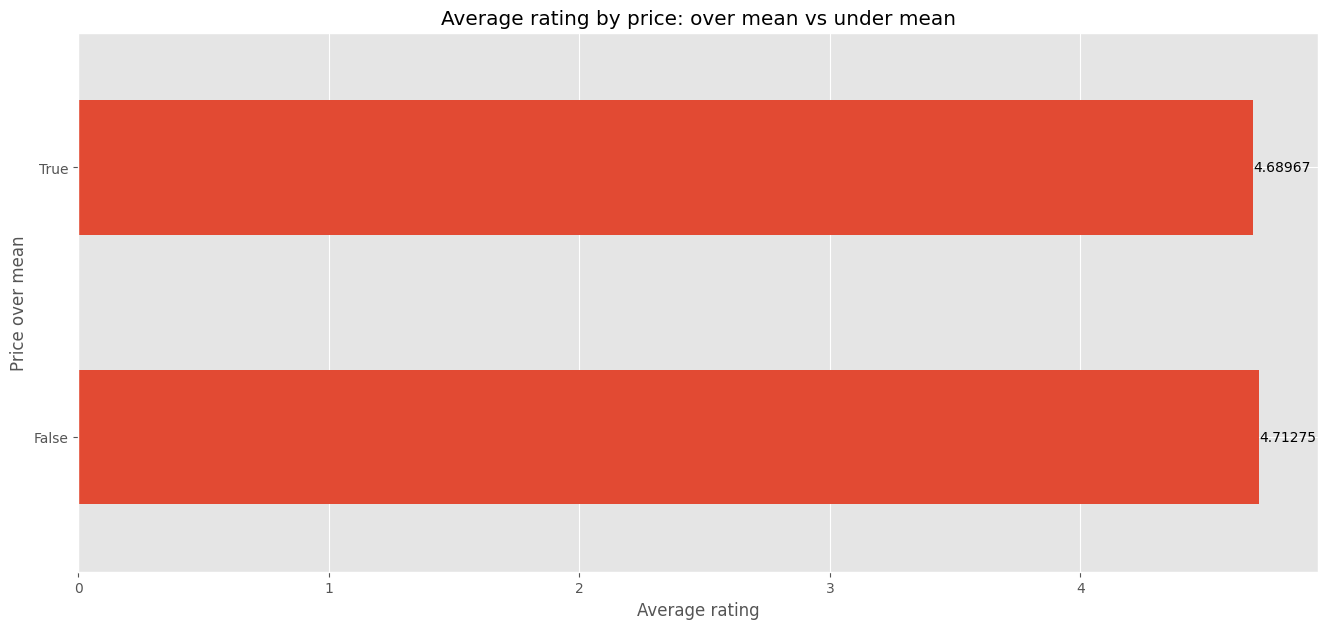

In [31]:
df['price_over_mean'] = df['price'] > df['mean_price']
rating_over_mean = df.groupby('price_over_mean').agg({
    'average_review_rating': 'mean',
})

fig, ax = plt.subplots(figsize=(16, 7))

rating_over_mean['average_review_rating'].plot(
    kind='barh',
    ax=ax,
    title='Average rating by price: over mean vs under mean',
    xlabel='Average rating',
    ylabel='Price over mean',
)

ax.bar_label(ax.containers[0])

### Price variance vs Number of reviews: inverse proportionality

<Axes: title={'center': 'Price variance vs Number of reviews'}, xlabel='Number of reviews', ylabel='Price variance'>

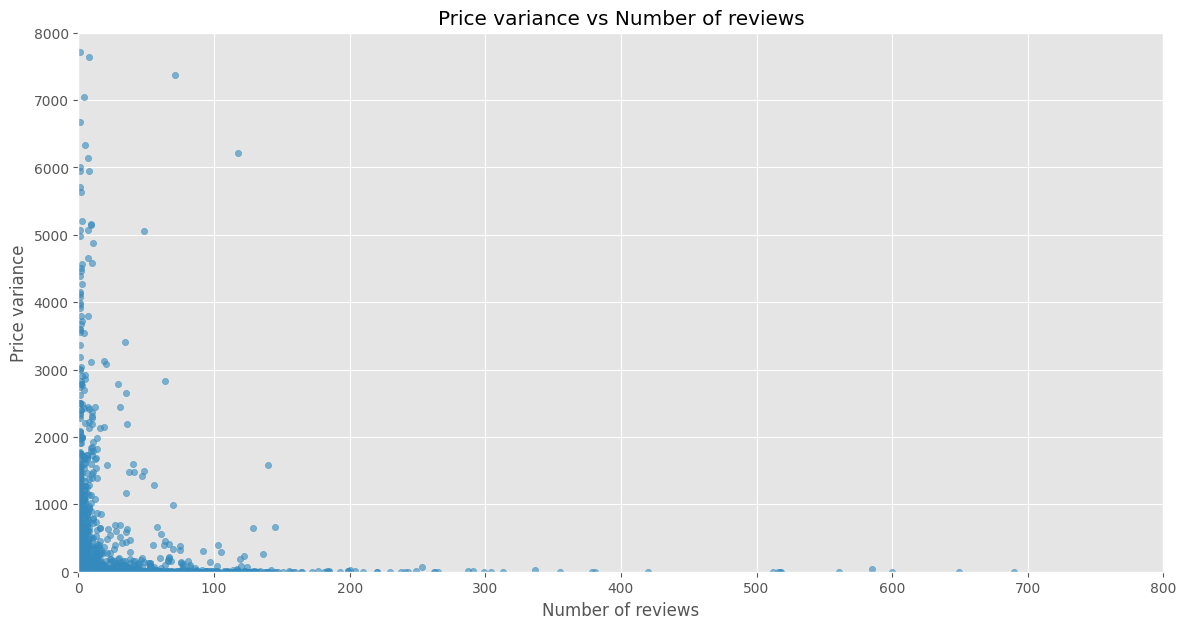

In [32]:
fig, ax = plt.subplots(figsize=(14, 7))

df.plot(
    kind='scatter',
    x='number_of_reviews',
    y='price_variance',
    title='Price variance vs Number of reviews',
    xlabel='Number of reviews',
    ylabel='Price variance',
    xlim=(0, 800),
    ylim=(0, 8000),
    ax=ax,
    alpha=0.6
)